In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import skew
import math

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate
)

%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv', index_col='id')

# EDA

In [3]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [4]:
train.isnull().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [5]:
train.describe()

,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,2.491511,0.488719,46.112575,1.187970,0.352377
std,1.120434,0.272563,15.788521,0.895961,0.166417
min,1.000000,0.000000,25.000000,0.000000,0.000000
25%,1.000000,0.260000,35.000000,1.000000,0.230000
50%,2.000000,0.510000,45.000000,1.000000,0.340000
75%,3.000000,0.710000,60.000000,2.000000,0.460000
max,4.000000,1.000000,70.000000,7.000000,1.000000


In [6]:
train[(train['num_reported_accidents'] == 0) & (train['accident_risk'] > 0.8) & (train['curvature'] > 0.6)]

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
3003,rural,1,0.88,60,night,foggy,True,False,afternoon,True,True,0,0.81
4655,urban,1,0.88,70,night,foggy,False,True,morning,False,False,0,0.82
5871,rural,4,0.87,70,night,foggy,True,False,morning,False,True,0,0.83
9028,urban,2,1.00,60,night,foggy,True,True,morning,True,True,0,0.81
9504,urban,3,0.90,60,night,foggy,False,False,morning,False,False,0,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...
510213,rural,3,0.87,70,night,foggy,False,True,evening,True,True,0,0.81
510433,rural,3,0.95,60,night,rainy,True,True,morning,True,True,0,0.81
512150,rural,4,0.61,60,night,foggy,True,False,morning,False,True,0,0.92


In [7]:
train[(train['speed_limit'] == 60) & (train['road_type'] == 'urban')]

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
15,urban,1,0.52,60,daylight,clear,False,True,afternoon,True,False,1,0.39
23,urban,1,0.41,60,night,foggy,True,False,afternoon,True,False,0,0.68
57,urban,3,0.98,60,dim,clear,False,False,afternoon,True,False,2,0.52
62,urban,3,0.31,60,daylight,foggy,False,False,evening,False,True,2,0.31
78,urban,4,0.10,60,dim,clear,True,True,afternoon,True,False,1,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517672,urban,1,0.18,60,dim,foggy,False,True,evening,True,False,0,0.25
517673,urban,1,0.06,60,daylight,rainy,True,True,afternoon,True,False,1,0.39
517681,urban,1,0.01,60,night,clear,False,False,morning,False,True,2,0.33


#### There is something peculiar about the data that accident risk above 0.8 has num_reported_accidents to be zero. From the fitlered dataset, I can see that curvature, speed_limit, lighting and weather have heavy influence over accident risk.

<Axes: xlabel='accident_risk'>

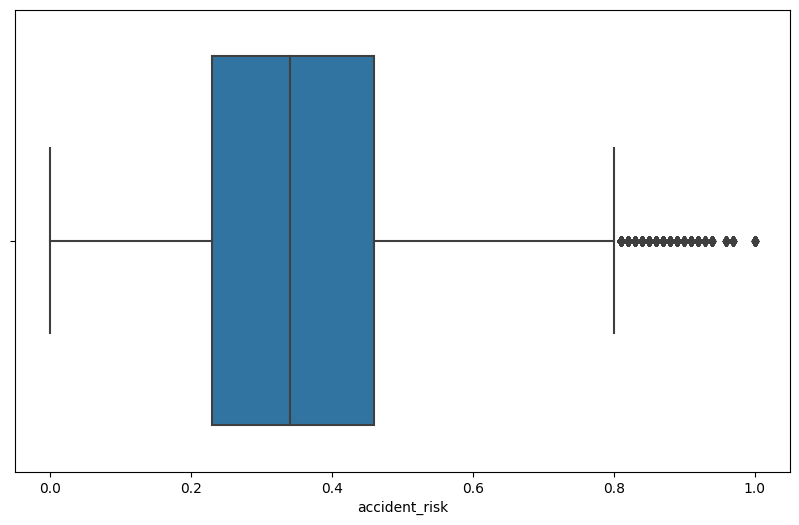

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train['accident_risk'])

We can see from the boxplot that accident_risk above 0.8 has outliers.

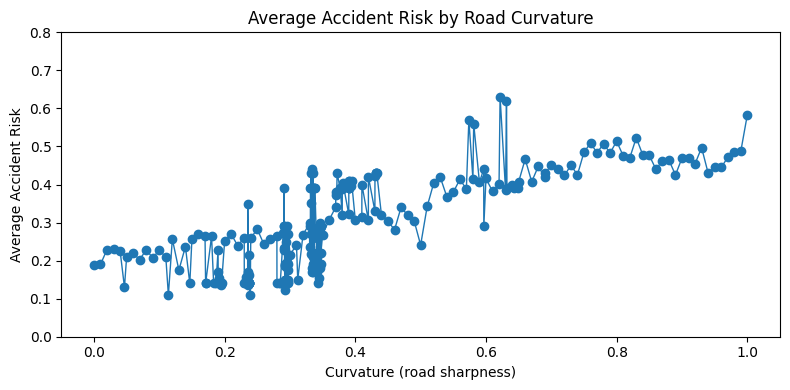

In [9]:
curv_target = train.groupby('curvature')['accident_risk'].mean().sort_index()

plt.figure(figsize=(8,4))
curv_target.plot(kind='line', marker='o', linewidth=1)

plt.xlabel('Curvature (road sharpness)')      
plt.ylabel('Average Accident Risk')             
plt.title('Average Accident Risk by Road Curvature')  
plt.ylim(0.0, 0.8)
plt.tight_layout()
plt.show()


### Key insights:
* There is an overall upward trend meaning increase in curvature leads to increase in average accident risk

## Binning of curvature feature

In [10]:
labels = ['low', 'medium', 'high', 'extreme high']
train['curv_bin'] = pd.qcut(train['curvature'], q=4, labels=labels)

In [11]:
train['curv_bin'].value_counts()

curv_bin
low             133449
high            130076
medium          127926
extreme high    126303
Name: count, dtype: int64

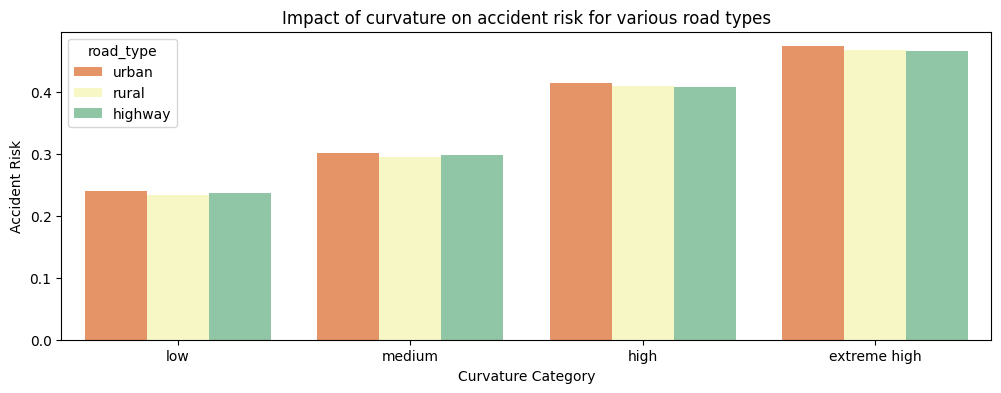

In [12]:
plt.figure(figsize=(12, 4))
sns.barplot(x='curv_bin', y='accident_risk', data=train, hue='road_type', palette='Spectral', estimator='mean',  # Explicitly specify the aggregation function
    errorbar=None, )
plt.title('Impact of curvature on accident risk for various road types')
plt.ylabel('Accident Risk')
plt.xlabel('Curvature Category')
plt.show()

### The categorical plot above gives us a clear picture that accident risk for all road types tends to increase as the curvature level increases.

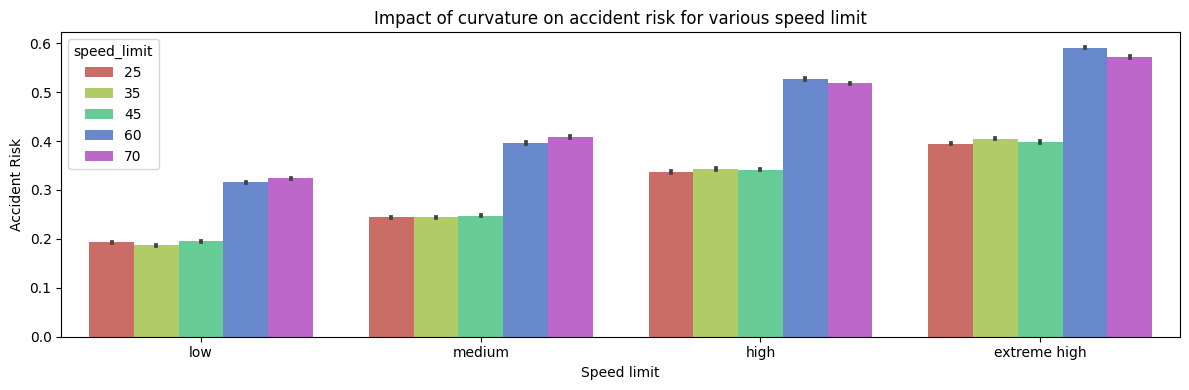

In [13]:
plt.figure(figsize=(12, 4))
sns.barplot(x='curv_bin', y='accident_risk', data=train, hue='speed_limit', palette='hls')
plt.title('Impact of curvature on accident risk for various speed limit')
plt.ylabel('Accident Risk')
plt.xlabel('Speed limit')
plt.tight_layout()

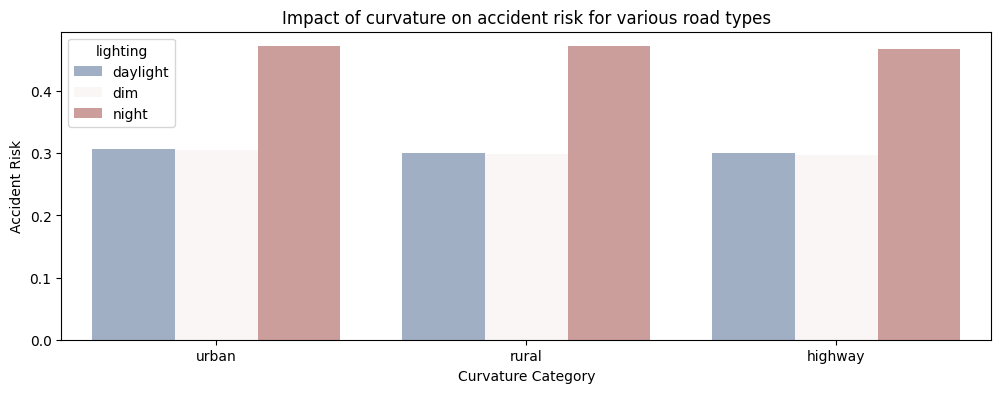

In [14]:
plt.figure(figsize=(12, 4))
sns.barplot(x='road_type', y='accident_risk', data=train, hue='lighting', palette='vlag', estimator='mean',  # Explicitly specify the aggregation function
    errorbar=None)
plt.title('Impact of curvature on accident risk for various road types')
plt.ylabel('Accident Risk')
plt.xlabel('Curvature Category')
plt.show()

### We can view from the chart above that during night time for extreme curvature, the accidents tends to be higher for all types of roads. During daylight and dim lighting, the accident risk for all road types at 0.3.

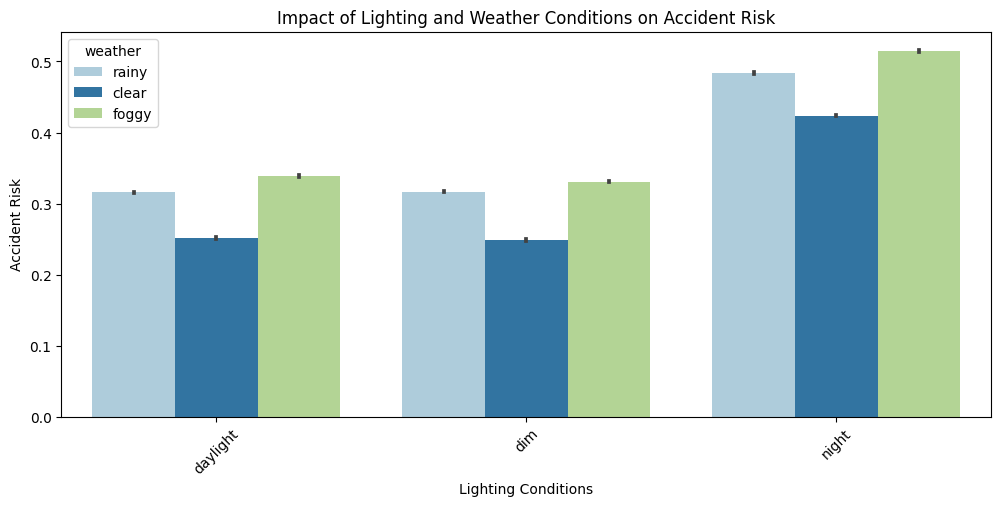

In [15]:
plt.figure(figsize=(12, 5))
g = sns.barplot(x='lighting', y='accident_risk', data=train, hue='weather', palette='Paired')
plt.xlabel("Lighting Conditions")
plt.title("Impact of Lighting and Weather Conditions on Accident Risk")
plt.ylabel('Accident Risk')
plt.xticks(rotation=45)
plt.show()

### We can conclude from the bar chart that foggy weather during night time has a higher accident risk above 0.5.

In [16]:
train.columns

Index(['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk',
       'curv_bin'],
      dtype='object')

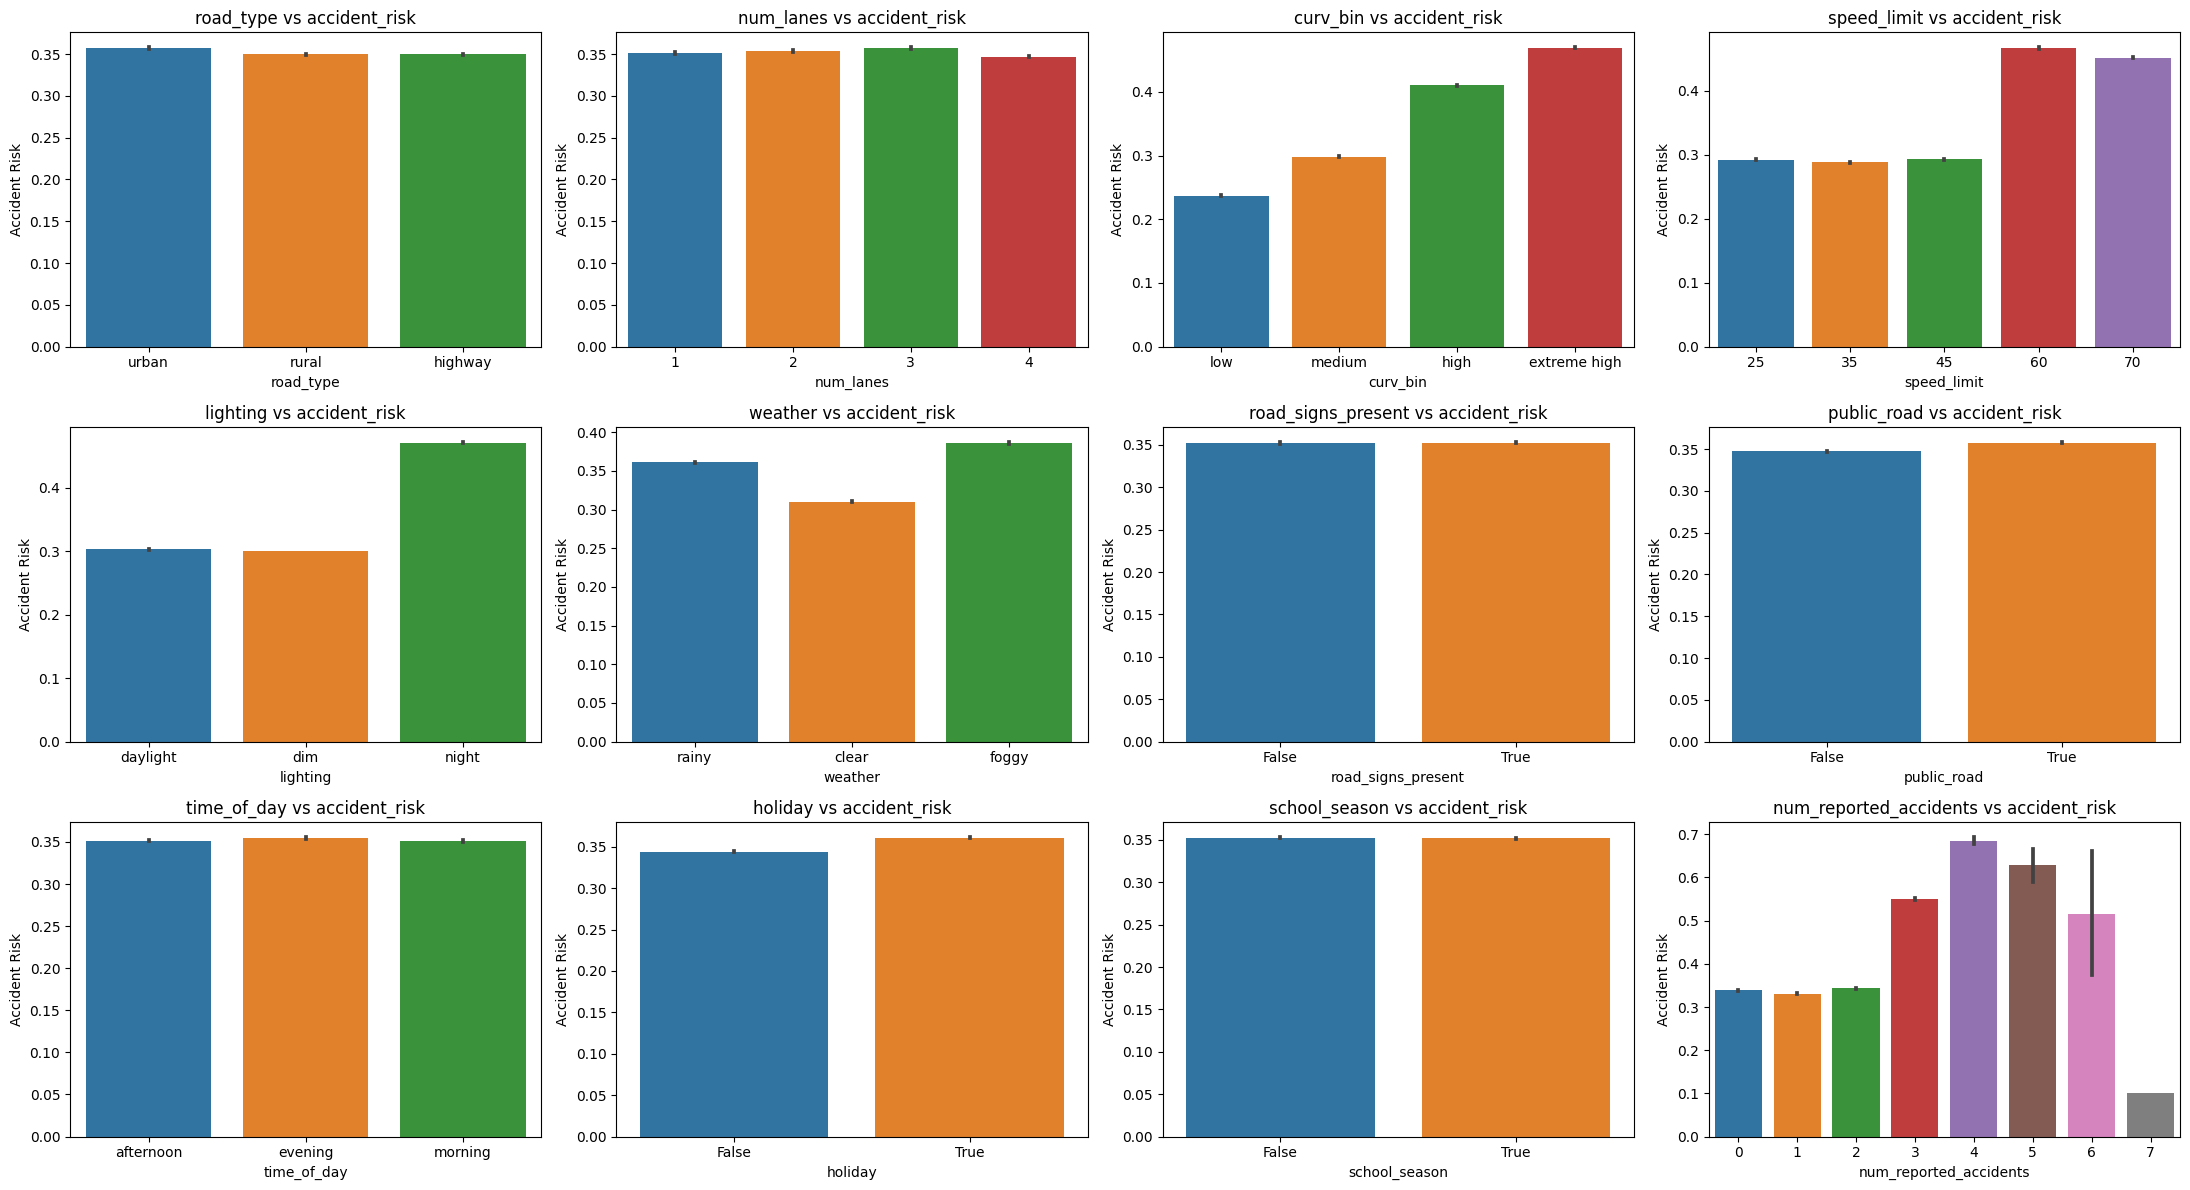

In [17]:
features = ['road_type', 'num_lanes', 'curv_bin', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents']
target = 'accident_risk'

n = len(features)
cols = 4 
rows = math.ceil(n / cols)

plt.figure(figsize=(22, rows * 4))

for i, col in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    sns.barplot(x=train[col], y=train[target])
    plt.title(f'{col} vs {target}')
    plt.ylabel('Accident Risk')
    
plt.tight_layout()
plt.show()